## Processing Ocean Color Imagery

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import os, glob
import multiprocessing

panelNames = None
useDLS = True

skyImagePath = os.path.join('data', 'first_ocean_color_images', '0001SET', 'sky')
seaImagePath = os.path.join('data', 'first_ocean_color_images', '0001SET', 'sea')
panelNames = glob.glob(os.path.join('../','ocean_color','data', 'first_ocean_color_images', '0001SET', 'panels','IMG_0021_*.tif'))
panelCap = capture.Capture.from_filelist(panelNames)

outputPath = os.path.join(seaImagePath,'..','stacks')
thumbnailPath = os.path.join(outputPath, '..', 'thumbnails')

overwrite = False # can be set to set to False to continue interrupted processing
generateThumbnails = True

# Allow this code to align both radiance and reflectance images; bu excluding
# a definition for panelNames above, radiance images will be used
# For panel images, efforts will be made to automatically extract the panel information
# but if the panel/firmware is before Altum 1.3.5, RedEdge 5.1.7 the panel reflectance
# will need to be set in the panel_reflectance_by_band variable.
# Note: radiance images will not be used to properly create NDVI/NDRE images below.
if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)
else:
    panelCap = None

if panelCap is not None:
    if panelCap.panel_albedo() is not None and not any(v is None for v in panelCap.panel_albedo()):
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order
    
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
else:
    if useDLS:
        img_type='reflectance'
    else:
        img_type = "radiance"

In [4]:
## This progress widget is used for display of the long-running process
f = FloatProgress(min=0, max=1, layout=Layout(width='100%'), description="Loading")
display(f)
def update_f(val):
    if (val - f.value) > 0.005 or val == 1: #reduces cpu usage from updating the progressbar by 10x
        f.value=val

%time seaimgset = imageset.ImageSet.from_directory(seaImagePath, progress_callback=update_f)
update_f(1.0)

FloatProgress(value=0.0, description='Loading', layout=Layout(width='100%'), max=1.0)

CPU times: user 488 ms, sys: 34.8 ms, total: 523 ms
Wall time: 1.42 s


In [5]:
## This progress widget is used for display of the long-running process
f = FloatProgress(min=0, max=1, layout=Layout(width='100%'), description="Loading")
display(f)
def update_f(val):
    if (val - f.value) > 0.005 or val == 1: #reduces cpu usage from updating the progressbar by 10x
        f.value=val

%time skyimgset = imageset.ImageSet.from_directory(skyImagePath, progress_callback=update_f)
update_f(1.0)

FloatProgress(value=0.0, description='Loading', layout=Layout(width='100%'), max=1.0)

CPU times: user 302 ms, sys: 29.3 ms, total: 331 ms
Wall time: 1.03 s


In [6]:
import math
import numpy as np
from mapboxgl.viz import *
from mapboxgl.utils import df_to_geojson, create_radius_stops, scale_between
from mapboxgl.utils import create_color_stops
import pandas as pd

data, columns = skyimgset.as_nested_lists()
df = pd.DataFrame.from_records(data, index='timestamp', columns=columns)

#Insert your mapbox token here
token = 'pk.eyJ1IjoibWljYXNlbnNlIiwiYSI6ImNqYWx5dWNteTJ3cWYzMnBicmZid3g2YzcifQ.Zrq9t7GYocBtBzYyT3P4sw'
color_property = 'dls-yaw'
num_color_classes = 8

min_val = df[color_property].min()
max_val = df[color_property].max()

import jenkspy
breaks = jenkspy.jenks_breaks(df[color_property], nb_class=num_color_classes)

color_stops = create_color_stops(breaks,colors='YlOrRd')
geojson_data = df_to_geojson(df,columns[3:],lat='latitude',lon='longitude')

viz = CircleViz(geojson_data, access_token=token, color_property=color_property,
                color_stops=color_stops,
                center=[df['longitude'].median(),df['latitude'].median()], 
                zoom=16, height='600px',
                style='mapbox://styles/mapbox/satellite-streets-v9')
viz.show()

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

def get_warp_matrix(img_capture, img_type, max_alignment_iterations = 10):
    ## Alignment settings
    match_index = 1 # Index of the band 
    warp_mode = cv2.MOTION_HOMOGRAPHY # MOTION_HOMOGRAPHY or MOTION_AFFINE. For Altum images only use HOMOGRAPHY
    pyramid_levels = 0 # for images with RigRelatives, setting this to 0 or 1 may improve alignment
    print("Aligning images. Depending on settings this can take from a few seconds to many minutes")
    # Can potentially increase max_iterations for better results, but longer runtimes
    warp_matrices, alignment_pairs = imageutils.align_capture(img_capture,
                                                              ref_index = match_index,
                                                              max_iterations = max_alignment_iterations,
                                                              warp_mode = warp_mode,
                                                              pyramid_levels = pyramid_levels)

    print("Finished Aligning, warp matrices={}".format(warp_matrices))
    return(warp_matrices)

warp_matrices = get_warp_matrix(skyimgset.captures[4], img_type)

Alinging images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 1
Finished aligning band 0
Finished aligning band 4
Finished aligning band 2
Finished aligning band 3
Finished Aligning, warp matrices=[array([[ 1.0013529e+00,  2.5713246e-04, -1.5120535e-01],
       [ 3.0701046e-04,  1.0006915e+00,  4.1502327e-02],
       [ 8.4948749e-07,  5.8410052e-07,  1.0000000e+00]], dtype=float32), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32), array([[ 1.0013292e+00,  9.3992305e-05, -1.7890982e-02],
       [ 2.8403601e-04,  9.9997282e-01,  4.4696155e-01],
       [ 1.1038973e-06,  1.8627080e-07,  1.0000000e+00]], dtype=float32), array([[ 1.0002068e+00, -1.3148688e-03,  2.6153752e-01],
       [ 4.2601026e-04,  9.9830127e-01,  5.6133652e-01],
       [ 1.0956245e-06, -1.9461759e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0008597e+00,  3.3581673e-04, -5.1601946e-02],
       [ 9.8492485e-05,  1.0000771e+00,  4.5892793e-

In [217]:
import exiftool
import datetime
## This progress widget is used for display of the long-running process
f2 = FloatProgress(min=0, max=1, layout=Layout(width='100%'), description="Saving")
display(f2)
def update_f2(val):
    f2.value=val

if not os.path.exists(outputPath):
    os.makedirs(outputPath)
if generateThumbnails and not os.path.exists(thumbnailPath):
    os.makedirs(thumbnailPath)

# Save out geojson data so we can open the image capture locations in our GIS
with open(os.path.join(outputPath,'imageSet.json'),'w') as f:
    f.write(str(geojson_data))
    
try:
    irradiance = panel_irradiance+[0]
except NameError:
    irradiance = None

start = datetime.datetime.now()
for i,capture in enumerate(skyimgset.captures):
    outputFilename = capture.uuid+'.tif'
    thumbnailFilename = capture.uuid+'.jpg'
    fullOutputPath = os.path.join(outputPath, outputFilename)
    fullThumbnailPath= os.path.join(thumbnailPath, thumbnailFilename)
    if (not os.path.exists(fullOutputPath)) or overwrite:
        if(len(capture.images) == len(skyimgset.captures[0].images)):
            capture.compute_undistorted_reflectance(irradiance_list=panel_irradiance,force_recompute=True)
            capture.create_aligned_capture(irradiance_list=panel_irradiance, warp_matrices=warp_matrices)
            capture.save_capture_as_stack(fullOutputPath)
            if generateThumbnails:
                capture.save_capture_as_rgb(fullThumbnailPath)
    capture.clear_image_data()
    update_f2(float(i)/float(len(skyimgset.captures)))
update_f2(1.0)
end = datetime.datetime.now()

print("Saving time: {}".format(end-start))
print("Alignment+Saving rate: {:.2f} images per second".format(float(len(skyimgset.captures))/float((end-start).total_seconds())))

FloatProgress(value=0.0, description='Saving', layout=Layout(width='100%'), max=1.0)

Saving time: 0:00:00.010926
Alignment+Saving rate: 915.25 images per second


In [194]:
def decdeg2dms(dd):
   is_positive = dd >= 0
   dd = abs(dd)
   minutes,seconds = divmod(dd*3600,60)
   degrees,minutes = divmod(minutes,60)
   degrees = degrees if is_positive else -degrees
   return (degrees,minutes,seconds)

header = "SourceFile,\
GPSDateStamp,GPSTimeStamp,\
GPSLatitude,GpsLatitudeRef,\
GPSLongitude,GPSLongitudeRef,\
GPSAltitude,GPSAltitudeRef,\
FocalLength,\
XResolution,YResolution,ResolutionUnits\n"

lines = [header]
for capture in skyimgset.captures:
    #get lat,lon,alt,time
    outputFilename = capture.uuid+'.tif'
    fullOutputPath = os.path.join(outputPath, outputFilename)
    lat,lon,alt = capture.location()
    #write to csv in format:
    # IMG_0199_1.tif,"33 deg 32' 9.73"" N","111 deg 51' 1.41"" W",526 m Above Sea Level
    latdeg, latmin, latsec = decdeg2dms(lat)
    londeg, lonmin, lonsec = decdeg2dms(lon)
    latdir = 'North'
    if latdeg < 0:
        latdeg = -latdeg
        latdir = 'South'
    londir = 'East'
    if londeg < 0:
        londeg = -londeg
        londir = 'West'
    resolution = capture.images[0].focal_plane_resolution_px_per_mm

    linestr = '"{}",'.format(fullOutputPath)
    linestr += capture.utc_time().strftime("%Y:%m:%d,%H:%M:%S,")
    linestr += '"{:d} deg {:d}\' {:.2f}"" {}",{},'.format(int(latdeg),int(latmin),latsec,latdir[0],latdir)
    linestr += '"{:d} deg {:d}\' {:.2f}"" {}",{},{:.1f} m Above Sea Level,Above Sea Level,'.format(int(londeg),int(lonmin),lonsec,londir[0],londir,alt)
    linestr += '{}'.format(capture.images[0].focal_length)
    linestr += '{},{},mm'.format(resolution,resolution)
    linestr += '\n' # when writing in text mode, the write command will convert to os.linesep
    lines.append(linestr)

fullCsvPath = os.path.join(outputPath,'log.csv')
with open(fullCsvPath, 'w') as csvfile: #create CSV
    csvfile.writelines(lines)

In [195]:
import subprocess

if os.environ.get('exiftoolpath') is not None:
    exiftool_cmd = os.path.normpath(os.environ.get('exiftoolpath'))
else:
    exiftool_cmd = 'exiftool'
        
cmd = '{} -csv="{}" -overwrite_original {}'.format(exiftool_cmd, fullCsvPath, outputPath)
print(cmd)
subprocess.check_call(cmd)

exiftool -csv="../ocean_color/data/first_ocean_color_images/0001SET/sea/../stacks/log.csv" -overwrite_original ../ocean_color/data/first_ocean_color_images/0001SET/sea/../stacks


FileNotFoundError: [Errno 2] No such file or directory: 'exiftool -csv="../ocean_color/data/first_ocean_color_images/0001SET/sea/../stacks/log.csv" -overwrite_original ../ocean_color/data/first_ocean_color_images/0001SET/sea/../stacks': 'exiftool -csv="../ocean_color/data/first_ocean_color_images/0001SET/sea/../stacks/log.csv" -overwrite_original ../ocean_color/data/first_ocean_color_images/0001SET/sea/../stacks'

### Exploring Variability of Ocean Color Data
visualize all the band values as histograms

look into the varability of each image's bottom 5,25,10,5,1 % of values

look into the variability of the median of the sky values

look into chl variability calculated from different images based on different darkest pixels

In [196]:
len(skyimgset.captures)

10

In [ ]:
6,7,8,9,10,12
6,10,12

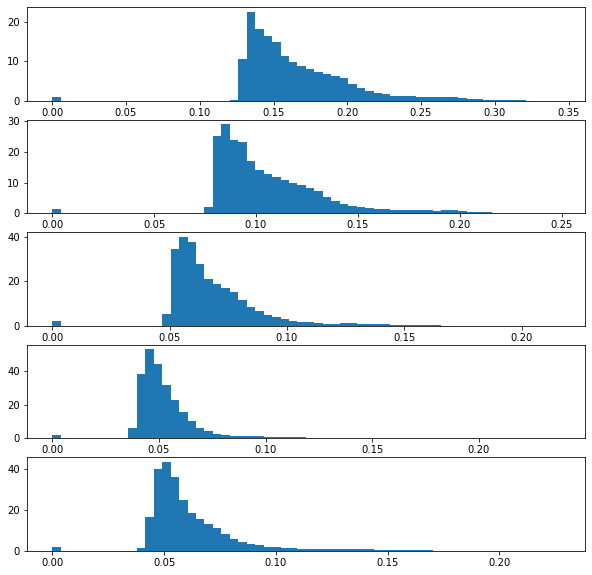

In [296]:
fig, ax = plt.subplots(5,1, figsize=(10,10))

for idx, im in enumerate(skyimgset.captures[-1].images):
    
    ax[idx].hist(im.undistorted_reflectance().flatten(), density=True, bins=60)

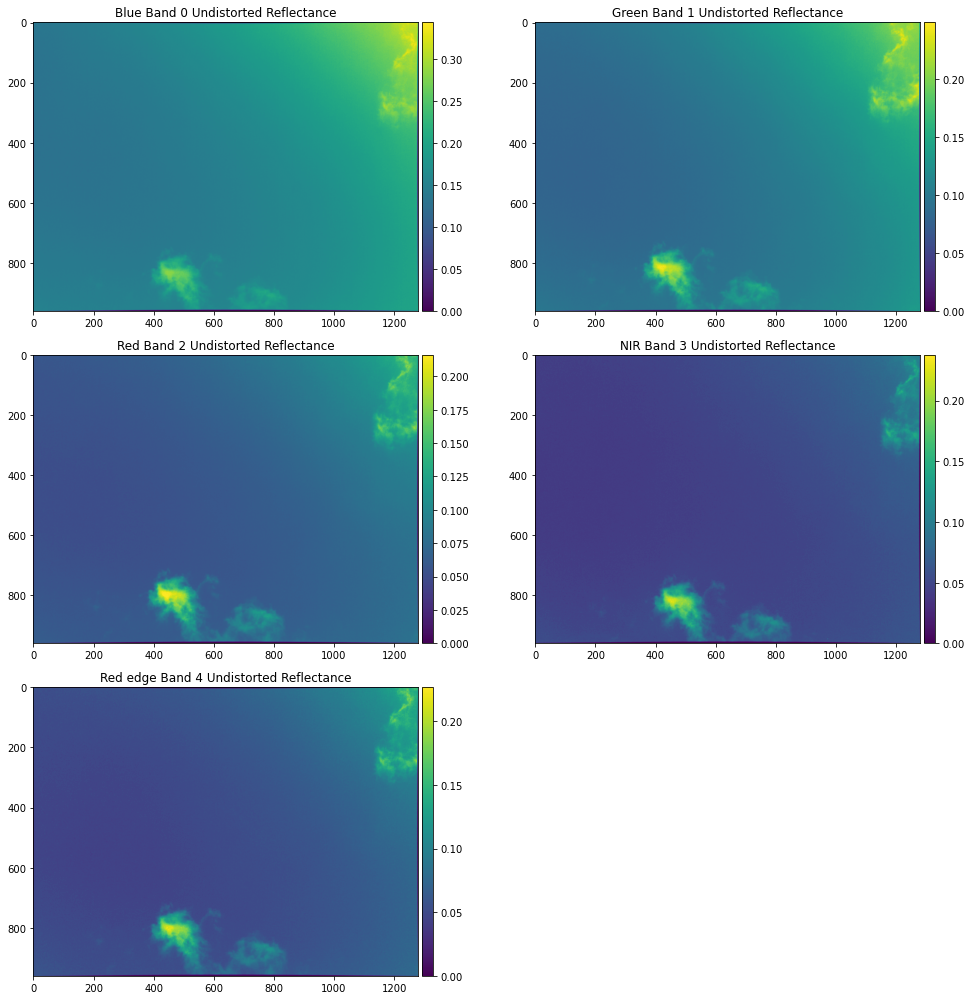

In [295]:
skyimgset.captures[-1].plot_undistorted_reflectance(panel_irradiance)

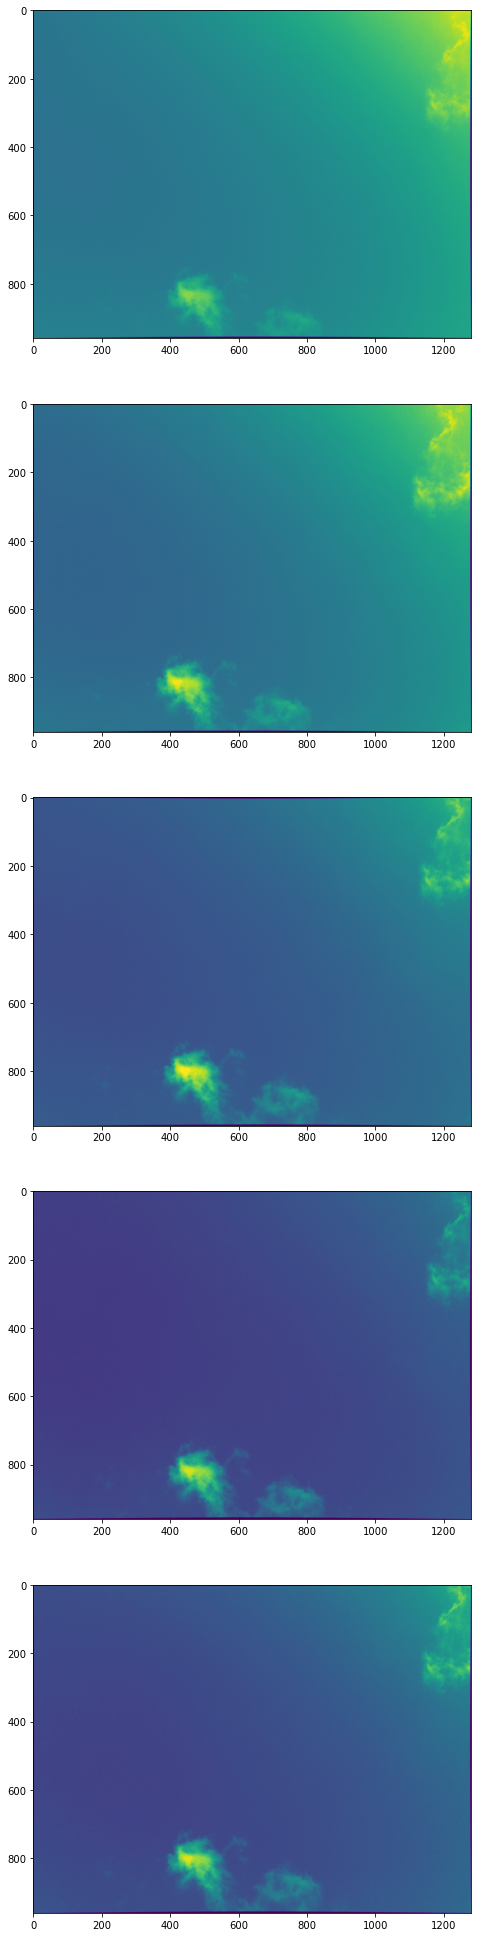

In [297]:
fig, ax = plt.subplots(5,1, figsize=(20,35))

for idx, im in enumerate(skyimgset.captures[-1].images):
    ax[idx].imshow(im.undistorted_reflectance())

In [181]:
# ignoring any zero values find the lowest 10% of the NIR band
list_of_lowest = []

In [ ]:
6,7,8,9,10,12
6,10,12
0,1,2,3,4,5,11

sorting  122880


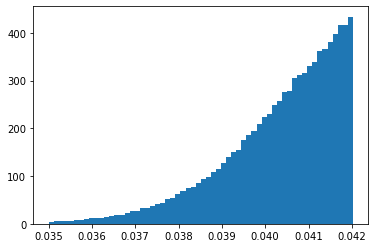

In [298]:
mean_lowest = []
sky_spectra = []

#for capture_num in range(0,len(seaimgset.captures)):
for capture_num in [-1]:
    lowest_percent = 0.1
    num_to_sort = int(skyimgset.captures[capture_num].images[0].undistorted_reflectance().size * lowest_percent)
    print('sorting ', num_to_sort)
    nir_idx = seaimgset.captures[capture_num].band_names_lower().index('nir')
    
    # efficiently sort the array
    flat_array = skyimgset.captures[capture_num].images[nir_idx].undistorted_reflectance().flatten()
    flat_array[flat_array == 0 ] = 1
    flat_array[flat_array < 0.035 ] = 1
    idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
    
    plt.hist(flat_array[idx], density=True, bins=60)
    mean_lowest.append(np.mean(flat_array[idx]))
    for img_idx in range(0,5):
        sky_spectra.append(np.mean(skyimgset.captures[capture_num].images[img_idx].undistorted_reflectance().flatten()[idx]))


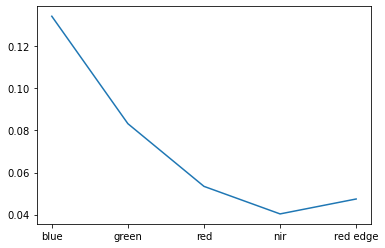

In [299]:
plt.plot(skyimgset.captures[4].band_names_lower(), sky_spectra)

In [624]:
seaimgset.captures[capture_num].band_names_lower()

['blue', 'green', 'red', 'nir', 'red edge']

sorting  122880
sorting  122880
sorting  122880
sorting  122880
sorting  122880
sorting  122880
sorting  122880


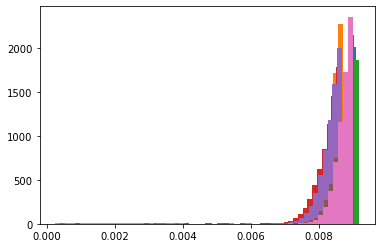

In [632]:
mean_lowest = []
list_of_spectra = []

#for capture_num in range(0,len(seaimgset.captures)):
for capture_num in [0,1,2,3,4,5,11]:
    spectra = []
    lowest_percent = .1
    num_to_sort = int(seaimgset.captures[capture_num].images[0].undistorted_reflectance().size * lowest_percent)
    print('sorting ', num_to_sort)
    nir_idx = seaimgset.captures[capture_num].band_names_lower().index('red edge')
    
    # efficiently sort the array
    flat_array = seaimgset.captures[capture_num].images[nir_idx].undistorted_reflectance().flatten()
    flat_array[flat_array == 0 ] = 1
    #flat_array[flat_array < 0.0035 ] = 1
    idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
    
    plt.hist(flat_array[idx], density=True, bins=60)
    mean_lowest.append(np.mean(flat_array[idx]))
    for img_idx in range(0,5):
        spectra.append(np.mean(seaimgset.captures[capture_num].images[img_idx].undistorted_reflectance().flatten()[idx]))
    list_of_spectra.append(spectra)
list_of_lowest.append(mean_lowest)

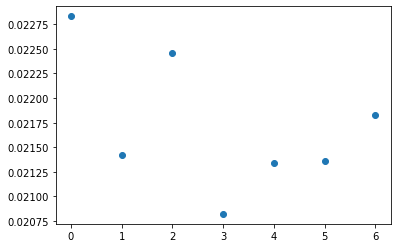

In [608]:
plt.scatter(range(7), mean_lowest)

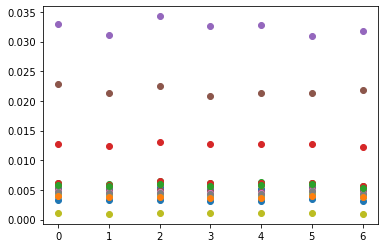

In [609]:
for lowest in list_of_lowest:
    plt.scatter(range(7), lowest)

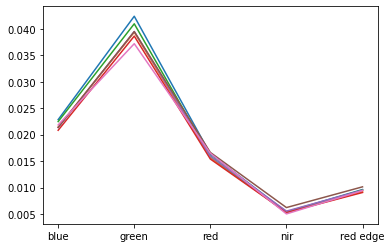

In [610]:
for spectra in list_of_spectra:
    plt.plot(seaimgset.captures[capture_num].band_names_lower(), spectra)

In [310]:
sky_spectra

[0.13424933374817044,
 0.08321388530182797,
 0.05343618510453354,
 0.04035282171979579,
 0.047442234874906945]

In [311]:
sky_spectra

[0.13424933374817044,
 0.08321388530182797,
 0.05343618510453354,
 0.04035282171979579,
 0.047442234874906945]

In [312]:
wind = 3
water_leaving_spectra = []
for water_spec in list_of_spectra:
    water_leaving = np.array(water_spec) - np.array(sky_spectra) * (0.0256 + 0.00039 * wind + 0.000034 * wind * wind)
    water_leaving_spectra.append(water_leaving)

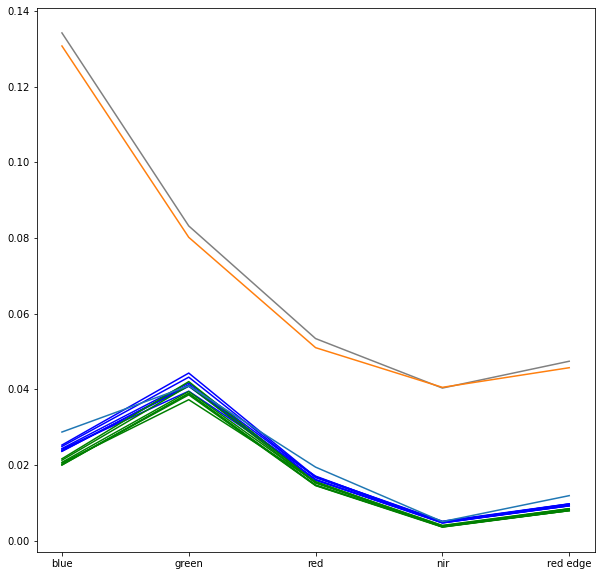

In [318]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(skyimgset.captures[4].band_names_lower(), sky_spectra, color='grey')

for spectra in list_of_spectra:
    ax.plot(seaimgset.captures[capture_num].band_names_lower(), spectra, color='blue')
    
for spectra in water_leaving_spectra:
    ax.plot(seaimgset.captures[capture_num].band_names_lower(), spectra, color='green')
    
ax.plot(seaimgset.captures[capture_num].band_names_lower(), [0.0287275 , 0.04094633, 0.0194484 , 0.00504329, 0.01190834])
ax.plot(seaimgset.captures[capture_num].band_names_lower(), [0.13079345, 0.08020303, 0.05103283, 0.04054285, 0.04573154])

In [314]:
def L2chlor_a(Rrs443, Rrs488, Rrs547, Rrs555, Rrs667):
    ''' Use weighted MODIS Aqua bands to calculate chlorophyll concentration
    using oc3m blended algorithm with CI (Hu et al. 2012) '''

    thresh = [0.15, 0.20]
    a0 = 0.2424
    a1 = -2.7423
    a2 = 1.8017
    a3 = 0.0015
    a4 = -1.2280

    ci1 = -0.4909
    ci2 = 191.6590
    
    if Rrs443 > Rrs488:
        Rrsblue = Rrs443
    else:
        Rrsblue = Rrs488

    log10chl = a0 + a1 * (np.log10(Rrsblue / Rrs547)) \
        + a2 * (np.log10(Rrsblue / Rrs547))**2 \
            + a3 * (np.log10(Rrsblue / Rrs547))**3 \
                + a4 * (np.log10(Rrsblue / Rrs547))**4

    oc3m = np.power(10, log10chl)

    CI = Rrs555 - ( Rrs443 + (555 - 443)/(667 - 443) * \
        (Rrs667 -Rrs443) )
        
    ChlCI = 10** (ci1 + ci2*CI)

    if ChlCI <= thresh[0]:
        chlor_a = ChlCI
    elif ChlCI > thresh[1]:
        chlor_a = oc3m
    else:
        chlor_a = oc3m * (ChlCI-thresh[0]) / (thresh[1]-thresh[0]) +\
            ChlCI * (thresh[1]-ChlCI) / (thresh[1]-thresh[0])

    return chlor_a


In [315]:
chla_list = []
for spectra in water_leaving_spectra:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)

In [316]:
chla_list

[14.954215494394903,
 14.98611952855677,
 14.480595709983385,
 15.014047900897248,
 13.968178021870644,
 13.882773338641629,
 11.657209764412126]

### Calculate Chl-a Across the Whole Image

In [331]:
full_sea_img = []
for img_idx in range(0,5):
    full_sea_img.append(seaimgset.captures[-1].images[img_idx].undistorted_reflectance().flatten())
full_sea_img = np.array(full_sea_img)

In [337]:
sky_rad_correction = np.reshape(np.array(sky_spectra) * (0.0256 + 0.00039 * wind + 0.000034 * wind * wind), (5,1))
water_leaving = full_sea_img - sky_rad_correction

In [339]:
water_leaving.shape

(5, 1228800)

In [364]:
chlas = []
for i in range(water_leaving.shape[-1]):
    chlas.append(L2chlor_a(water_leaving[0,i],water_leaving[0,i],water_leaving[1,i],water_leaving[1,i],water_leaving[2,i]))

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


In [451]:
chlas = np.array(chlas)

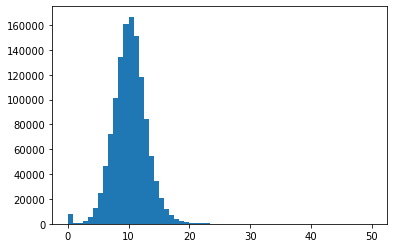

In [452]:
plt.hist(chlas, range=(0,50), bins=60)
plt.show()

In [453]:
np.nanmax(chlas)

4365.122024934244

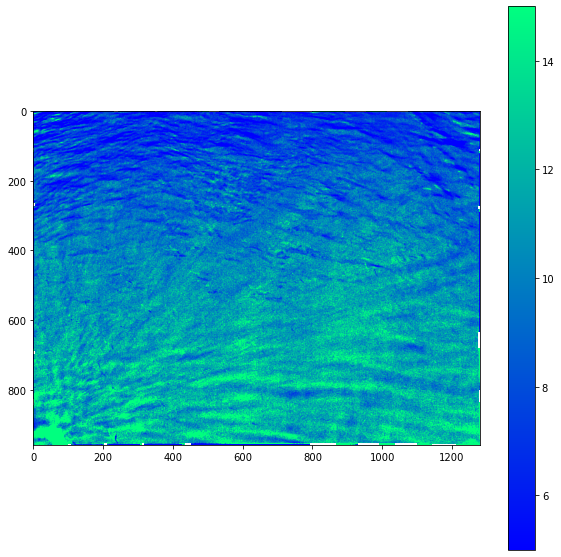

In [454]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(np.reshape(chlas,(960, 1280)), vmin=5, vmax=15, cmap='winter')
fig.colorbar(im)

In [633]:
selected_pix = np.zeros(flat_array.shape[0], dtype=np.int)
selected_pix[idx] = 1

In [634]:
np.unique(selected_pix)

array([0, 1])

In [635]:
selected_pix[flat_array == 0 ] = 0
selected_pix[flat_array < 0.0035 ] = 0
selected_pix[flat_array > 1 ] = 0

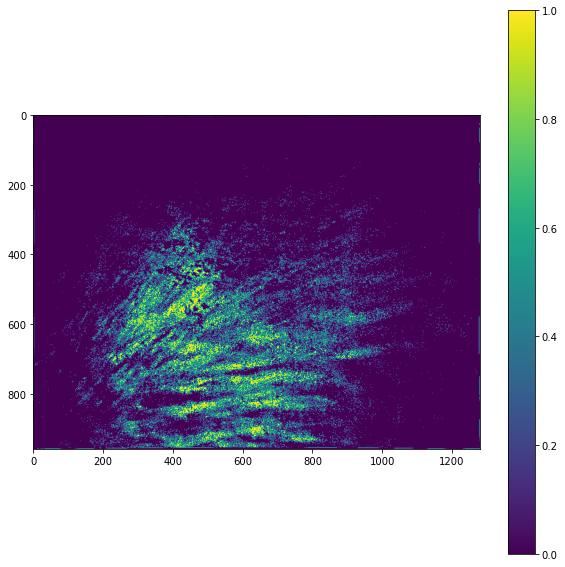

In [636]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(np.reshape(selected_pix,(960, 1280)))
fig.colorbar(im)

In [637]:
chlas

array([  1.06918105,   4.25718288,   7.39999911, ..., 102.4735359 ,
       122.40470703,  84.21683414])

In [638]:
chla_pix = np.zeros(flat_array.shape[0])
chla_pix[idx] = chlas[idx]

In [639]:
chla_pix[chla_pix > 25] = 25
chla_pix[flat_array < 0.0035 ] = 0
chla_pix[flat_array > 1 ] = 0

In [640]:
chla_pix[chla_pix == 0] = np.nan

In [641]:
np.nanmax(chla_pix)

25.0

In [642]:
np.nanmedian(chla_pix)

11.357427156291521

<function matplotlib.pyplot.show(close=None, block=None)>

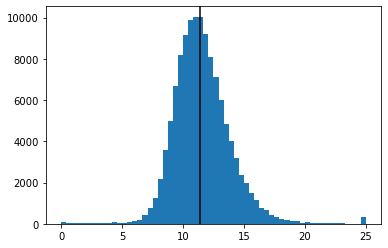

In [643]:
plt.hist(chla_pix, density=False, bins=60)
plt.axvline(x=np.nanmedian(chla_pix), color='black')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

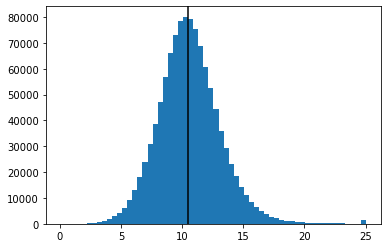

In [590]:
plt.hist(chla_pix, density=False, bins=60)
plt.axvline(x=np.nanmedian(chla_pix), color='black')
plt.show

In [622]:
np.count_nonzero(~np.isnan(chla_pix)) / chla_pix.size

0.09963948567708333

<function matplotlib.pyplot.show(close=None, block=None)>

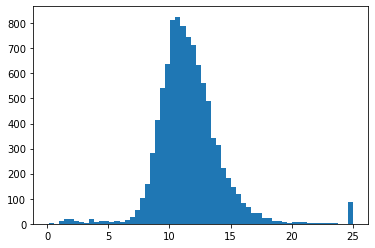

In [576]:
plt.hist(chla_pix, density=False, bins=60)
plt.show

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  after removing the cwd from sys.path.


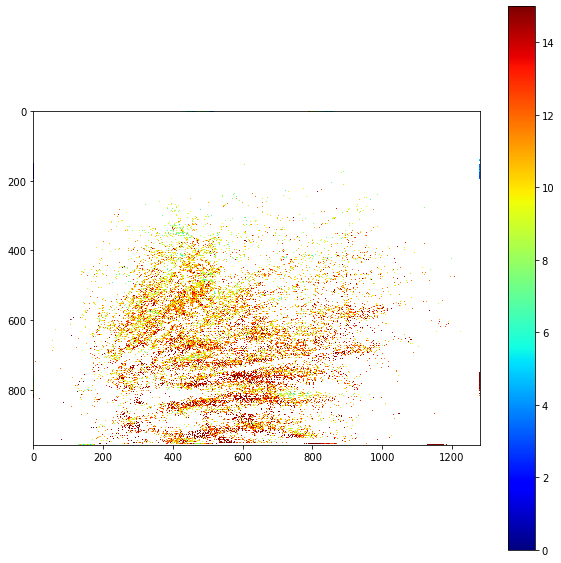

In [644]:
fig, ax = plt.subplots(figsize=(10,10))

cmap = matplotlib.cm.jet
cmap.set_bad('white',1.)

im = ax.imshow(np.reshape(chla_pix,(960, 1280)), vmin=0, vmax=15, interpolation='nearest', cmap=cmap)
fig.colorbar(im)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  after removing the cwd from sys.path.


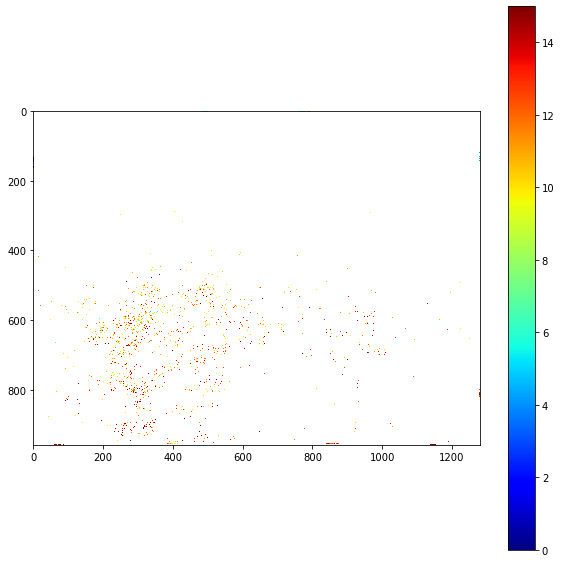

In [578]:
fig, ax = plt.subplots(figsize=(10,10))

cmap = matplotlib.cm.jet
cmap.set_bad('white',1.)

im = ax.imshow(np.reshape(chla_pix,(960, 1280)), vmin=0, vmax=15, interpolation='nearest', cmap=cmap)
fig.colorbar(im)